In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../BBTRE_physics_analysis/") 

In [3]:
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm
import numpy as np
import pandas as pd

from osse import *
from canyon_utils import *
from sloped_MITgcm import *
from wmt import *
nancol = (0.65,0.65,0.65)

In [4]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 15.

In [5]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon/input/"

In [6]:
ds = xr.open_dataset(data_dir+"geocoords_original.nc")
newds = xr.open_dataset(data_dir+"geocoords.nc")
cdf = pd.read_csv("../../data/BBTRE_hydrography_hab-binned.csv").groupby("cast number (CTD)", dropna=True).mean()

In [7]:
min_elv = newds.attrs['min_elv']
Hz = newds.attrs['Hz']
dz0 = newds.attrs['dz0']

Hbot = newds['z'] - min_elv - (Hz - dz0)

Hremoved = newds['z_slope'] + min_elv
Hoffset = Hremoved + (Hz-dz0)

In [8]:
lon1 = -18.3; lon2 = lon1; lon3 = lon1; 
lat1 = -21.7; lat2 = lat1; lat3 = lat1;

In [9]:
x = newds['Xr'].values[:]
z = newds['Z'].values[:]

sec_j = newds['Yr'].size//2-4


# Moorings
geo = xr.open_dataset(data_dir+"geocoords.nc").drop(["X", "Y"])
moorings = {
    #"CTS17-P1": {'coords': (-14.58, -21.12)},
    "CTS17-P2": {'coords': (-14.59, -21.10)},
    "T05": {'coords': (-17.-48.5/60., -21.-36.9/60.)}
}

lons = [mooring['coords'][0] for mooring in moorings.values()]
lats = [mooring['coords'][1] for mooring in moorings.values()]
markers = ['v', 's']#['o', 'v', 's']
samples = sample_locations(geo, lons, lats)

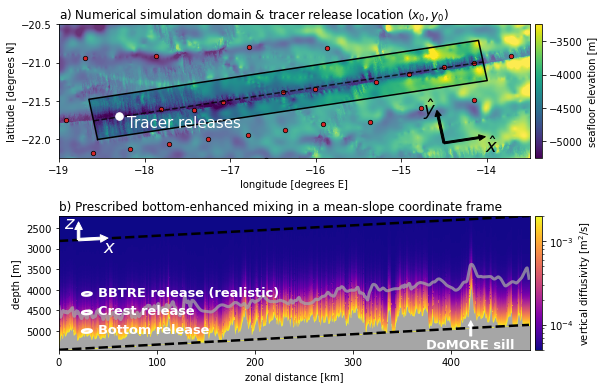

In [10]:
labels = ["c)", "d)", "e)", "f)"]

plt.rcParams['font.size'] = 10

scale_fig = 0.55
fig = plt.figure(figsize=(16*scale_fig,10*scale_fig))
gs = fig.add_gridspec(2, 4)

### XY
ax1 = fig.add_subplot(gs[0, :])

clims = [-5250, -3250]
q = ds['z'].plot.pcolormesh(x='lon', y='lat')
plt.fill_between([-25, -10], [-30, -30], [0, 0], facecolor="w", alpha=0.20)
q.set_rasterized(True)
q.set_clim(clims)
q.colorbar.remove()
q = (newds['z_actual']).plot(x='lon', y='lat')
q.set_clim(clims)
q.colorbar.remove()
plt.colorbar(q, pad=0.01, label=r"seafloor elevation [m]")

for c in cdf.index:
    plt.plot(cdf[cdf.index==c]['longitude'], cdf[cdf.index==c]['latitude'],
             "C3.", markersize=9, markeredgecolor="k", markeredgewidth=0.75)

# Domain limits (and center axis)
plt.plot([newds['lon'].isel(Xr=0, Yr=sec_j), newds['lon'].isel(Xr=-1, Yr=sec_j)], [newds['lat'].isel(Xr=0, Yr=sec_j), newds['lat'].isel(Xr=-1, Yr=sec_j)], "k--", alpha=0.75)
plt.plot(
    [newds['lon'].isel(Xr=0, Yr=0), newds['lon'].isel(Xr=0, Yr=-1), newds['lon'].isel(Xr=-1, Yr=-1), newds['lon'].isel(Xr=-1, Yr=0), newds['lon'].isel(Xr=0, Yr=0)],
    [newds['lat'].isel(Xr=0, Yr=0), newds['lat'].isel(Xr=0, Yr=-1), newds['lat'].isel(Xr=-1, Yr=-1), newds['lat'].isel(Xr=-1, Yr=0), newds['lat'].isel(Xr=0, Yr=0)],
    "k-"
)

plt.plot(lon1, lat1, "wo", markersize=7.5)
plt.annotate(text="Tracer releases", xy=(lon1+0.095, lat1-0.0825), horizontalalignment="left", verticalalignment="center", fontsize=15, color="w")

X0 = newds['lon'].isel(Xr=0, Yr=0);
Xx = newds['lon'].isel(Xr=-1, Yr=0);
Xy = newds['lon'].isel(Xr=0, Yr=-1);
Y0 = newds['lat'].isel(Xr=0, Yr=0);
Yx = newds['lat'].isel(Xr=-1, Yr=0);
Yy = newds['lat'].isel(Xr=0, Yr=-1)
Xa = -14.5; Ya = -22.05;
plt.arrow(Xa, Ya, (Xx-X0)*0.09, (Yx-Y0)*0.09, head_width = 0.075, head_length = 0.075, width=0.025, color="k")
plt.arrow(Xa, Ya, (Xy-X0)*0.67, (Yy-Y0)*0.67, head_width = 0.075, head_length = 0.075, width=0.025, color="k")
plt.annotate(text=r"$\hat{x}$", xy=(Xa+0.48, Ya-0.12), fontsize=18)
plt.annotate(text=r"$\hat{y}$", xy=(Xa-0.25, Ya+0.365), fontsize=18)
plt.title("")
plt.xlabel("longitude [degrees E]")
plt.ylabel("latitude [degrees N]")
plt.xticks(np.arange(-19, -13, 1))
plt.yticks(np.arange(-22.5, -20, 0.5))

plt.ylim([-22.25, -20.5])
plt.xlim([-19, -13.5])
plt.title(r"a) Numerical simulation domain & tracer release location ($x_{0}, y_{0}$)", loc='left')

### XZ
ax2 = fig.add_subplot(gs[1, :], facecolor=nancol)
q = plt.pcolor(x[np.newaxis,:]*1e-3, z[:,np.newaxis]+Hoffset.values,newds['K'][:,sec_j,:].values, norm=matplotlib.colors.LogNorm(vmin=5.e-5, vmax=2.e-3), cmap="plasma")
plt.xlabel('zonal distance [km]')
plt.ylabel('depth [m]')
plt.colorbar(q, pad=0.01, label=r"vertical diffusivity [m$^{2}$/s]")
plt.fill_between(x*1e-3, Hremoved - 10, Hbot[sec_j,:]+Hoffset, facecolor=nancol)
plt.fill_between(x*1e-3, Hremoved + (Hz-50.), np.zeros_like(x), facecolor=cm.plasma(0.))

plt.plot(x*1e-3, Hremoved, "k--", lw=2.5)
plt.plot(x*1e-3, Hremoved+(Hz-dz0), "k--", lw=2.5)
plt.plot(Hbot['Xr']*1e-3, (Hbot+Hoffset).isel(Yr=np.append(np.arange(-10,0), np.arange(0,10))).mean(dim='Yr'), color=nancol, lw=3.0, alpha=0.75)

plt.contour(x[np.newaxis,:]*1e-3 + 0.*z[:,np.newaxis], z[:,np.newaxis]+Hoffset.values, newds['BBTRE'].values[:,newds['Yr'].size//2,:], levels=[0.37], colors="w", linewidths=2.5)
plt.contour(x[np.newaxis,:]*1e-3 + 0.*z[:,np.newaxis], z[:,np.newaxis]+Hoffset.values, newds['Crest'].values[:,newds['Yr'].size//2,:], levels=[0.37], colors="w", linewidths=2.5)
plt.contour(x[np.newaxis,:]*1e-3 + 0.*z[:,np.newaxis], z[:,np.newaxis]+Hoffset.values, newds['Bottom'].values[:,newds['Yr'].size//2,:], levels=[0.37], colors="w", linewidths=2.5)

plt.annotate(text="BBTRE release (realistic)", xy=(40, -4150), color="w", fontsize=13, weight="bold")
plt.annotate(text="Crest release", xy=(40, -4600), color="w", fontsize=13, weight="bold")
plt.annotate(text="Bottom release", xy=(40, -5050), color="w", fontsize=13, weight="bold")
plt.annotate(
    text="DoMORE sill", xytext=(420, -5325), xy=(420, -4750), color="w", fontsize=13, weight="bold",
    va="center", ha="center",
    arrowprops=dict(headlength=5, width=2, headwidth=5, color='w')
)

plt.yticks(np.arange(-5000, -2000, 500), np.arange(5000, 2000, -500))

plt.xlim([0, 600.*newds['Xr'].size*1e-3])
plt.ylim([Hremoved.min(), (Hremoved + (Hz-dz0)).max()])

θ = 0.0012618506382207175
X0 = 20e3; Z0 = -2780;
Mag = 30e3;
arrowprops = dict(headlength=7.5, width=2.5, headwidth=7.5, color='w')
X1 = X0 + Mag*np.cos(θ); Z1 = Z0 + Mag*np.sin(θ)
plt.annotate("", (X1*1e-3, Z1), (X0*1e-3, Z0), arrowprops=arrowprops, xycoords="data")
scale = 1/70.
X2 = X0 - Mag*np.sin(θ)*scale; Z2 = Z0 + Mag*np.cos(θ)*scale
plt.annotate("", (X2*1e-3, Z2), (X0*1e-3, Z0), arrowprops=arrowprops, xycoords="data")
plt.annotate(text=r"$z$", xy=(X0*1e-3-15, Z0+285), fontsize=18, color="w")
plt.annotate(text=r"$x$", xy=(X0*1e-3+25, Z0-300), fontsize=18, color="w")
plt.title("b) Prescribed bottom-enhanced mixing in a mean-slope coordinate frame", loc='left')

plt.tight_layout()
plt.savefig(f"../../figures/BBTRE-tracer/domain_configuration.png", dpi=200., bbox_inches='tight')

In [11]:
from xmitgcm import open_mdsdataset 
delta_t = 15.

runname = "run"
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/{runname}/"
budget_diags = ["budgetDiag", "tracer01Diag", "tracer02Diag", "tracer03Diag"]
tracer = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=budget_diags, delta_t=delta_t)

tracer = tracer.sel(time=tracer['time'][1:])
Lx = tracer['XC'].size*dx
tracer = periodic_extend(tracer, ['XC', 'XG'], Lx, [-1,0])
xslice = [700, 800+300] # smaller domain for testing

tracer = tracer.isel(XC=slice(*xslice), XG=slice(*xslice))
tracer, grid = add_rotated_coords(tracer, θ)
tracer = tracer.chunk({'XC': -1, 'XG': -1})
tracer = tracer.assign_coords({'dV': tracer.drF * tracer.rA * tracer.hFacC})

tracer = tracer.assign_coords({'days': (tracer['time'].astype('float64')*1.e-9/86400.) - 5000.*(delta_t/60.)})

In [12]:
tracer['THETA'] = tracer['THETA'].where(tracer['THETA'] != 0.)
tracer['THETA_BG_C'] = Γ*tracer['Zr']
tracer['θ'] = tracer['THETA'] + tracer['THETA_BG_C']

In [13]:
# define the target values in density
θ_target = np.linspace(0, 2.5, 26)

# target variable
tracer["θ_outer"] = grid.interp(tracer["θ"], 'Z', boundary='fill', to="outer").chunk({'Zp1': -1})

# mask negative tracer values (they don't affect results, but break the log-scale colorbar below)
tracer["TRAC01"] = tracer["TRAC01"].where(tracer["TRAC01"] >= 0., 1.e-16)

In [14]:
def transform_to_θ(da, θ_outer, θ_target):
    return grid.transform(da,
                          'Z',
                          θ_target,
                          method='conservative',
                          target_data=θ_outer)

cdV = transform_to_θ(tracer["TRAC01"]*tracer["dV"], tracer["θ_outer"], θ_target)

/home/hdrake/.conda/envs/sim-bbtre-plus/lib/python3.10/site-packages/xgcm/grid.py:982: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/hdrake/.conda/envs/sim-bbtre-plus/lib/python3.10/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


In [15]:
M = cdV.isel(time=0).sum().values

In [16]:
vmax = cdV.isel(θ_outer=10, time=0).max().values

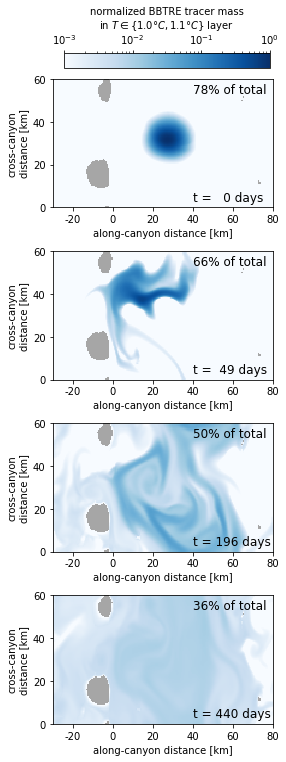

In [23]:
t_movs = np.int64(np.linspace(0, 21, 4)**2)
t_movs[-1] = 440
scale = 0.85
plt.figure(figsize=(4.8*scale, 12*scale))

cmap = copy.copy(matplotlib.cm.get_cmap("Blues"))
cmap.set_bad(color=nancol)

for i, t in enumerate(t_movs, start=1):
    plt.subplot(4,1,i)
    Mlayerfrac = np.int64(round(cdV.isel(θ_outer=10, time=t).sum(['XC', 'YC']).values/M * 100))
    
    PC = (cdV.isel(θ_outer=10, time=t)/vmax).plot(norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1), cmap=cmap)
    PC.colorbar.remove()
    plt.xlim(-3e4, 8e4)
    plt.xlabel("along-canyon distance [km]")
    xticks = np.arange(-20e3, 100e3, 20e3)
    plt.xticks(xticks, np.int64(xticks*1e-3))
    plt.ylabel("cross-canyon\ndistance [km]")
    yticks = np.arange(0e3, 80e3, 20e3)
    plt.yticks(yticks, np.int64(yticks*1e-3))
    plt.title("")
    tstr = (str(t).zfill(3))
    tstr = tstr[:-1].replace("0", " ") + tstr[-1]
    plt.annotate(text=fr"t = {tstr} days", xy=(40e3, 3e3), color="k", fontsize=12)
    plt.annotate(text=fr"{Mlayerfrac}% of total", xy=(40e3, 53.5e3), color="k", fontsize=12)
    
plt.tight_layout()

plt.subplots_adjust(top=0.935)
cax = plt.axes([0.23, 0.95, 0.7, 0.02])
cb = plt.colorbar(PC, cax=cax, orientation="horizontal", label="normalized BBTRE tracer mass\nin $T \in \{1.0\degree C, 1.1\degree C\}$ layer")
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.savefig(f"../../figures/BBTRE-tracer/tracer_snapshots.png", bbox_inches="tight", dpi=80.)

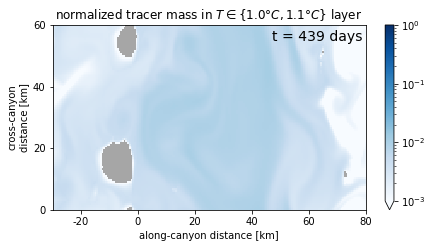

In [19]:
scale = 0.85
plt.figure(figsize=(scale*8.25, scale*4), facecolor="w")
for t in range(0, 440):
    plt.clf()
    (cdV.isel(θ_outer=10, time=t)/vmax).plot(norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1), cmap=cmap)
    plt.xlim(-3e4, 8e4)
    plt.xlabel("along-canyon distance [km]")
    xticks = np.arange(-20e3, 100e3, 20e3)
    plt.xticks(xticks, np.int64(xticks*1e-3))
    plt.ylabel("cross-canyon\ndistance [km]")
    yticks = np.arange(0e3, 80e3, 20e3)
    plt.yticks(yticks, np.int64(yticks*1e-3))
    plt.title("")
    tstr = (str(t).zfill(3))
    tstr = tstr[:-1].replace("0", " ") + tstr[-1]
    plt.annotate(text=fr"t = {tstr} days", xy=(47e3, 55e3), color="k", fontsize=14)
    plt.title("normalized tracer mass in $T \in \{1.0\degree C, 1.1\degree C\}$ layer")
    plt.savefig(f"../../figures/BBTRE-tracer/movies/layerTracer/layerTracer{str(t).zfill(4)}.png", bbox_inches="tight", dpi=100.)